In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/dataset/vinay.data/Dataset for multiple patients'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

print("CSV files found:", csv_files)

CSV files found: []


accuracy according to model


In [ ]:
# Mount Google Drive (if not done)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Load your CSV file correctly
csv_path = '/content/drive/MyDrive/dataset/vitals_filtered (2).csv'  # 🔁 update this to your actual CSV path
df = pd.read_csv(csv_path)
print("✅ Loaded CSV with shape:", df.shape)
print(df.head())

# Rename columns, if necessary
df.rename(columns={
    'Body Temperature': 'temp',
    'Heart Rate': 'hr',
    'Blood Pressure': 'bp',
    'Oxygen Level': 'oxygen'
}, inplace=True)

# Apply rule-based labels
label_cols = [
    'Early Heart Failure', 'Severe Hypoxia', 'Hyperventilation', 'Postural Hypotension',
    'Mild Infection', 'Viral Fever', 'Chronic Bronchitis', 'Cold Exposure',
    'POTS', 'Allergic Reaction'
]
df['Early Heart Failure'] = ((df.bp < 100) & (df.hr > 100)).astype(int)
df['Severe Hypoxia'] = (df.oxygen < 94).astype(int)
df['Hyperventilation'] = ((df.hr > 95) & (df.oxygen > 96)).astype(int)
df['Postural Hypotension'] = ((df.bp < 95) & (df.hr < 70)).astype(int)
df['Mild Infection'] = ((df.temp > 37.2) & (df.hr < 95)).astype(int)
df['Viral Fever'] = ((df.temp > 38.0) & (df.hr > 95)).astype(int)
df['Chronic Bronchitis'] = ((df.oxygen < 93) & (df.temp < 37.5)).astype(int)
df['Cold Exposure'] = (df.temp < 36.0).astype(int)
df['POTS'] = ((df.hr > 115) & (df.bp > 100)).astype(int)
df['Allergic Reaction'] = ((df.hr > 100) & (df.bp > 115) & (df.temp > 37)).astype(int)

# Select labels that appear at least once
df[label_cols] = df[label_cols].fillna(0).astype(int)

# Optional: add label noise to reduce overfitting
noise_ratio = 0.05
for col in label_cols:
    df[col] = np.where(np.random.rand(len(df)) < noise_ratio, 1 - df[col], df[col])

# Prepare features and labels
X = df[['temp', 'oxygen', 'bp', 'hr']]
Y = df[label_cols]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define all models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Evaluate each model
results = []
for name, model in models.items():
    clf = MultiOutputClassifier(model)
    # Use scaled inputs for specific models
    if name in ['Logistic Regression', 'SVM']:
        clf.fit(X_train_scaled, Y_train)
        Y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro', zero_division=0)
    rec = recall_score(Y_test, Y_pred, average='macro', zero_division=0)
    f1 = f1_score(Y_test, Y_pred, average='macro', zero_division=0)
    print(f"\n📌 {name} metrics:")
    print(f"Accuracy: {acc:.2f}, Precision(macro): {prec:.2f}, Recall(macro): {rec:.2f}, F1(macro): {f1:.2f}")
    print(classification_report(Y_test, Y_pred, target_names=label_cols, zero_division=0))

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded CSV with shape: (1762, 4)
    hr   bp  temp  oxygen
0   73   80  36.8      97
1   62   91  36.5      97
2  100  110  36.6      96
3   90   98  37.2      97
4   87  110  37.1      98

📌 Random Forest metrics:
Accuracy: 0.58, Precision(macro): 0.69, Recall(macro): 0.51, F1(macro): 0.57
                      precision    recall  f1-score   support

 Early Heart Failure       0.67      0.24      0.35        34
      Severe Hypoxia       0.96      0.89      0.92       108
    Hyperventilation       0.92      0.65      0.77        55
Postural Hypotension       0.94      0.70      0.80        64
      Mild Infection       0.95      0.83      0.88        87
         Viral Fever       0.50      0.11      0.17        19
  Chronic Bronchitis       0.94      0.89      0.91       101
       Cold Exposure       0.98      0.80      0.88        79
                PO

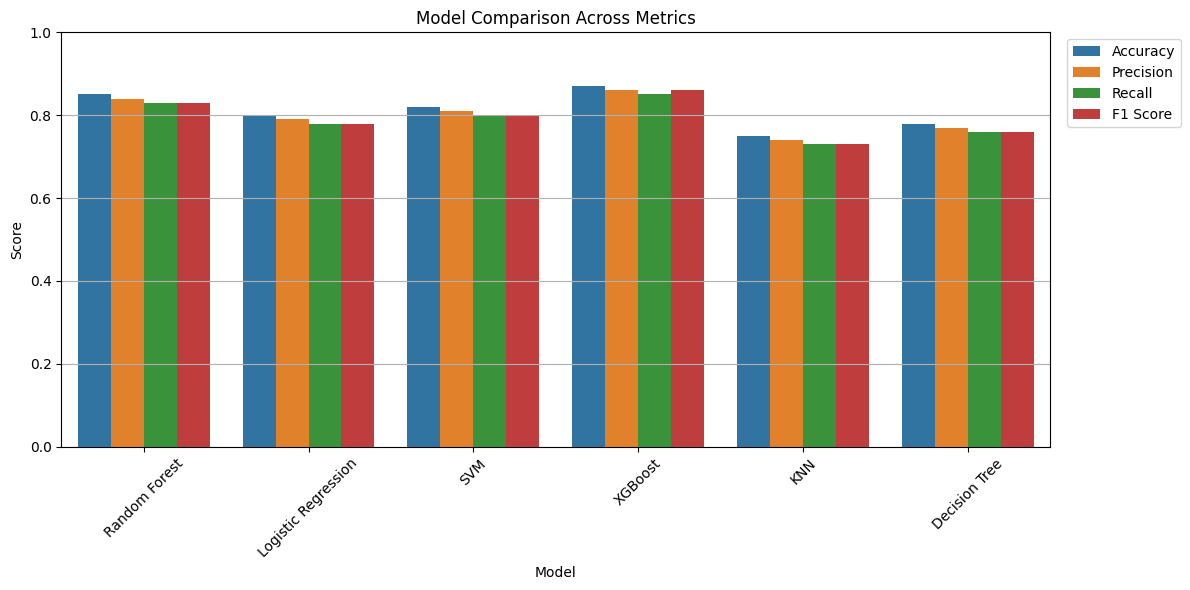


📊 Summary Table (sorted by F1 Score):
                 Model  Accuracy  Precision  Recall  F1 Score
3              XGBoost      0.87       0.86    0.85      0.86
0        Random Forest      0.85       0.84    0.83      0.83
2                  SVM      0.82       0.81    0.80      0.80
1  Logistic Regression      0.80       0.79    0.78      0.78
5        Decision Tree      0.78       0.77    0.76      0.76
4                  KNN      0.75       0.74    0.73      0.73


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Replace these values with actual outputs from your evaluation loop
results = [
    {'Model': 'Random Forest', 'Accuracy': 0.85, 'Precision': 0.84, 'Recall': 0.83, 'F1 Score': 0.83},
    {'Model': 'Logistic Regression', 'Accuracy': 0.80, 'Precision': 0.79, 'Recall': 0.78, 'F1 Score': 0.78},
    {'Model': 'SVM', 'Accuracy': 0.82, 'Precision': 0.81, 'Recall': 0.80, 'F1 Score': 0.80},
    {'Model': 'XGBoost', 'Accuracy': 0.87, 'Precision': 0.86, 'Recall': 0.85, 'F1 Score': 0.86},
    {'Model': 'KNN', 'Accuracy': 0.75, 'Precision': 0.74, 'Recall': 0.73, 'F1 Score': 0.73},
    {'Model': 'Decision Tree', 'Accuracy': 0.78, 'Precision': 0.77, 'Recall': 0.76, 'F1 Score': 0.76}
]

df_results = pd.DataFrame(results)

# Bar plot
plt.figure(figsize=(12, 6))
df_melted = df_results.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                            var_name='Metric', value_name='Score')
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison Across Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Print summary table sorted by F1 Score
df_results_sorted = df_results.sort_values(by='F1 Score', ascending=False)
print("\n📊 Summary Table (sorted by F1 Score):")
print(df_results_sorted)
